In [1]:
import requests
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import warnings

plt.rcParams['figure.figsize'] = (11, 7)

## Import monthly data

Let's import `Inmet` data and create rolling variables to smooth quantities.

In [213]:
# google drive shareable file link

orig_url = 'https://drive.google.com/file/d/1WQ9NARYCNZxWlQUAf4Zn5TxJcnOGjEn3/view?usp=sharing'

# get file id

file_id = orig_url.split('/')[-2]

# create download url

dwn_url='https://drive.google.com/uc?export=download&id=' + file_id

# get raw text inside url

url = requests.get(dwn_url).text

# create a buffer

csv_raw = StringIO(url)

# read from buffer

df = pd.read_csv(csv_raw, index_col=0)

# create sinop and dsinop series

sinop = df[(df['dc_nome']=='sinop') & (df['date'] >= '2007-01-01')]

sinop['date'] = pd.to_datetime(sinop['date'], format=('%Y-%m-%d')) 

sinop.set_index('date', inplace=True)

dsinop = sinop.chuva.diff()

# cut train period

train = sinop[(sinop.index >= '2007-01-01') & (sinop.index <= '2019-12-01')].chuva

test = sinop[sinop.index >= '2020-01-01'].chuva

dtrain = train.diff().dropna()

dtest = test.diff().dropna()

## Time series exploratory

Start of exploratory data analysis using time series framework.

In [3]:
import statsmodels.api as sm

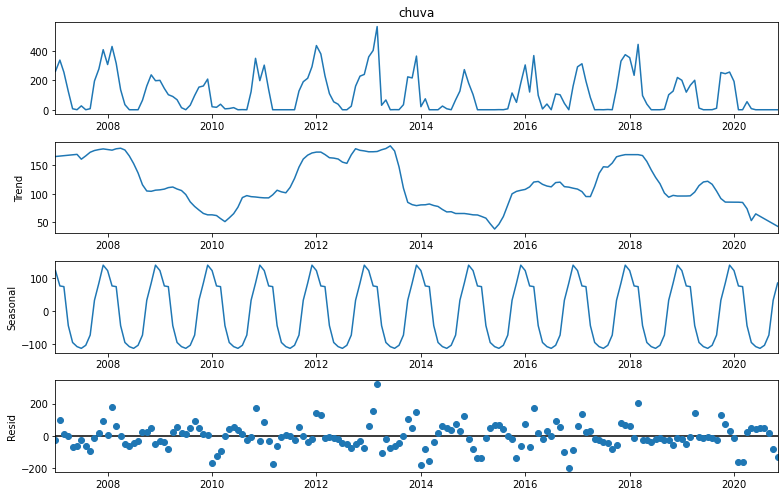

In [214]:
# time series decomposition

res = sm.tsa.seasonal_decompose(sinop.chuva, period=12, extrapolate_trend='freq')
resplot = res.plot()

<AxesSubplot:>

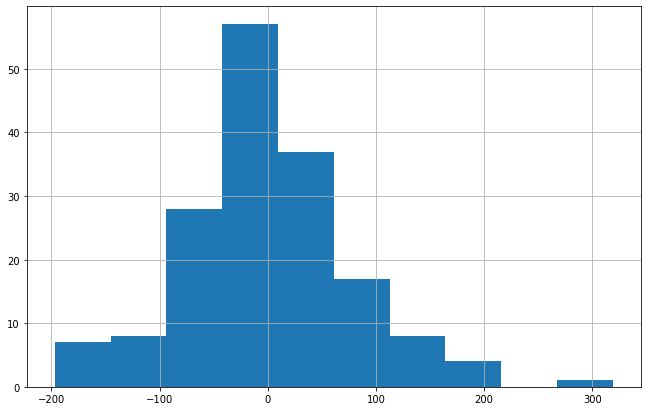

In [215]:
res.resid.hist()

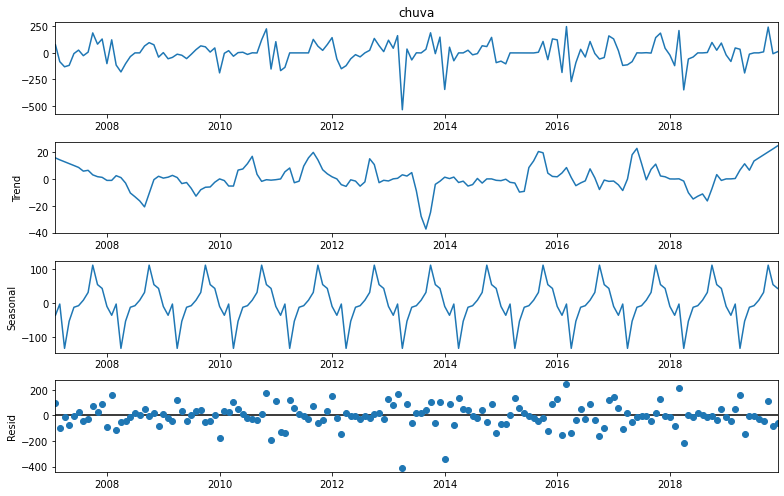

In [216]:
res = sm.tsa.seasonal_decompose(dtrain, period=12, extrapolate_trend='freq')
resplot = res.plot()

<AxesSubplot:>

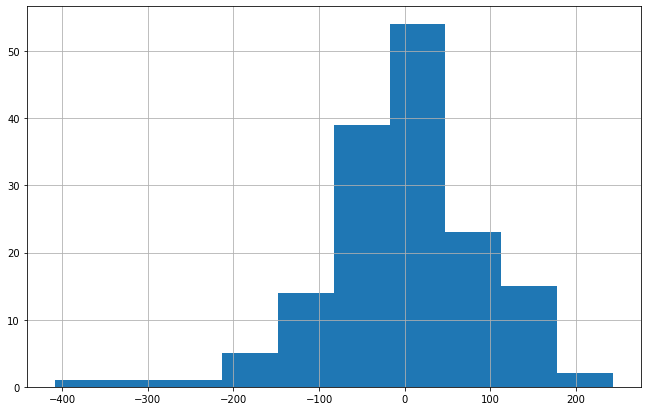

In [217]:
res.resid.hist()

In [223]:
# check for stationarity (ADF)

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

res_adf = adfuller(train)
res_kpss = kpss(train)

print('----- ADF -----')
print('\nADF Statistic: %f' % res_adf[0])
print('p-value: %f' % res_adf[1])
print('Lags used: %d' %res_adf[2])
print('Critical Values:')
for key, value in res_adf[4].items():
	print('\t%s: %.3f' % (key, value))
    

print('\n----- KPSSS -----')    
print('\nKPSS Statistic: %f' % res_kpss[0])
print('p-value: %f' % res_kpss[1])
print('Lags used: %d' %res_kpss[2])
print('Critical Values:')
for key, value in res_kpss[3].items():
	print('\t%s: %.3f' % (key, value))

----- ADF -----

ADF Statistic: -2.845528
p-value: 0.052059
Lags used: 10
Critical Values:
	1%: -3.476
	5%: -2.882
	10%: -2.578

----- KPSSS -----

KPSS Statistic: 0.081912
p-value: 0.100000
Lags used: 14
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


In [224]:
# check for stationarity (ADF)

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

res_adf = adfuller(dtrain)
res_kpss = kpss(dtrain)

print('----- ADF -----')
print('\nADF Statistic: %f' % res_adf[0])
print('p-value: %f' % res_adf[1])
print('Lags used: %d' %res_adf[2])
print('Critical Values:')
for key, value in res_adf[4].items():
	print('\t%s: %.3f' % (key, value))
    

print('\n----- KPSSS -----')    
print('\nKPSS Statistic: %f' % res_kpss[0])
print('p-value: %f' % res_kpss[1])
print('Lags used: %d' %res_kpss[2])
print('Critical Values:')
for key, value in res_kpss[3].items():
	print('\t%s: %.3f' % (key, value))

----- ADF -----

ADF Statistic: -7.645859
p-value: 0.000000
Lags used: 11
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578

----- KPSSS -----

KPSS Statistic: 0.096447
p-value: 0.100000
Lags used: 14
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


## Sarimax model

In [8]:
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions


In [9]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()

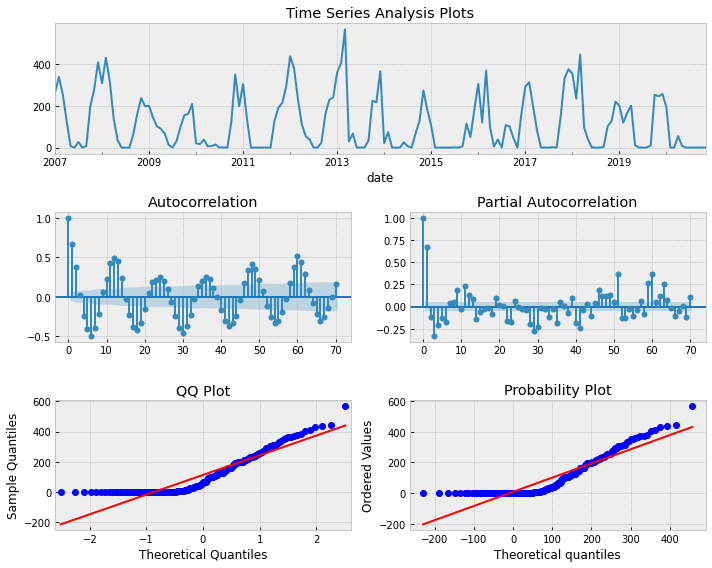

In [225]:
# plot ACF / PACF for series

tsplot(sinop.chuva, lags=70)

## SARIMA

Run `Sarima` w/ fixed parameters

                                        SARIMAX Results                                        
Dep. Variable:                                   chuva   No. Observations:                  156
Model:             SARIMAX(3, 0, 3)x(1, 0, [1, 2], 12)   Log Likelihood                -977.700
Date:                                 Mon, 28 Dec 2020   AIC                           1975.400
Time:                                         21:04:32   BIC                           2005.899
Sample:                                     01-01-2007   HQIC                          1987.788
                                          - 12-01-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5389      3.557      0.152      0.880      -6.432       7

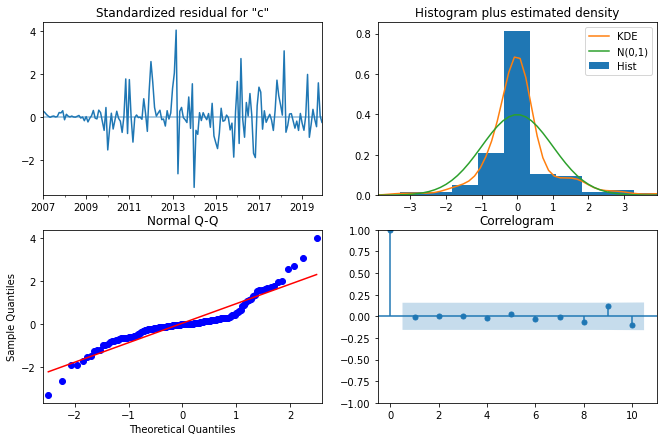

In [352]:
warnings.filterwarnings('ignore')

# parameters

def run_sarima(serie, p,d,q,P,D,Q,s):

    model = sm.tsa.statespace.SARIMAX(train, order=(p, d, q), 
                                                   seasonal_order=(P, D, Q, s),
                                                   simple_differencing=False,
                                                   initialization='approximate_diffuse').fit(disp=False)
    
    print(model.summary())
    
    return model

model = run_sarima(train, 3,0,3,1,0,2,12)

model.plot_diagnostics()
plt.show()

In [378]:
d = 0

def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    arima_model = model.fittedvalues
    
    # forecasting on n_steps forward
    
    forecast = model.predict(start = series.shape[0], end = series.shape[0]+n_steps)
    #conf_int = model.get_prediction(start=pd.to_datetime('2010-01-01'), 
    #                                end=pd.to_datetime('2020-12-01'), dynamic=False).conf_int()
    forecast = arima_model.append(forecast)
    forecast = forecast.clip(0)
    
    # calculate error, again having shifted on s+d steps from the beginning
    error = skm.mean_absolute_error(sinop.chuva[d:], forecast[d:])
    error2 = skm.mean_squared_error(sinop.chuva[d:], forecast[d:])
    
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Error: {0:.2f}".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(forecast.index[-11], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(sinop.chuva, label="actual")
    plt.fill_between(x=forecast.index,
                     y1=sinop.chuva,
                     y2=forecast,
                     alpha=0.3,
                     color=['tab:orange'],
                     hatch='///')
    plt.legend()
    plt.grid(True);
    conf_int=None
    
    return forecast

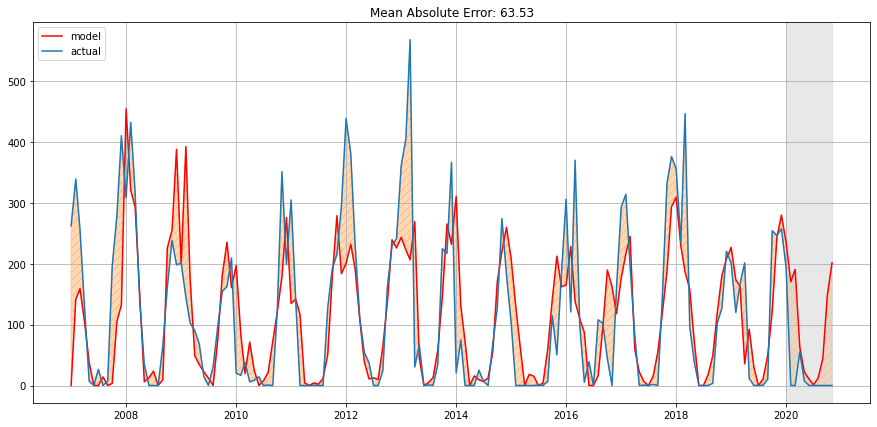

In [379]:
forecast = plotSARIMA(pd.DataFrame(train), model, 10)

## To-dos

- Aumentar a série de dados (target=30 anos);
<br></br>
- Fatores exógenos:
    - NOAA indicador El Nino / La Nina (-100,100)
    - Vazão afluente ($m^{3}/s$) aferida e projetada
<br></br>
- Teste de Jarque-Bera (target=3)

## Optmization

Try to find optimal parameters by iteration

In [326]:
# setting initial values and some bounds for them
ps = range(1, 3)
ds= range(0,2)
qs = range(1, 3)
Ps = range(1, 3)
Ds=range(0,1)
Qs = range(1, 3)
s = 12 # season length is 12

# creating list with all the possible combinations of parameters
parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
len(parameters_list)

32

In [327]:
warnings.filterwarnings('ignore')

def optimizeSARIMA(series, parameters_list, s, n_steps):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """
    
    dict_models = {}
    results = []
    best_aic = float("inf")
    # adding model values
    data = series.copy()
    data.columns = ['actual']

    for param in parameters_list:
        # we need try-except because on some combinations model fails to converge
        try:
            
            model=sm.tsa.statespace.SARIMAX(series, order=(param[0], param[1], param[2]), 
                                            seasonal_order=(param[3], param[4], param[5], s),
                                            simple_differencing=False,
                                            initialization='approximate_diffuse').fit(disp=False)
            
            data['arima_model'] = model.fittedvalues
            
            # forecasting on n_steps forward 
            
            forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps, typ='levels')
            
            forecast = forecast.clip(0)
            
            data['arima_model'] = data['arima_model'].append(forecast)
            
            data['arima_model'] = data['arima_model'].clip(0)
            
        except Exception as e:
            print(e)
            model = None
            continue
            
        aic = model.aic
        
        error = skm.mean_absolute_error(sinop.chuva[param[1]:], data['arima_model'][param[1]:])
        
        results.append([param, model.aic, error])
        dict_models[param]=model
    
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic', 'mae']
    
    return result_table, dict_models, forecast

In [328]:
%%time
result_table, dict_models, forecast = optimizeSARIMA(train,parameters_list, s, 10)

CPU times: user 22.1 s, sys: 17.6 s, total: 39.7 s
Wall time: 20.5 s


## NOAA Data

In [364]:
noaa = pd.read_csv('../../noaa_enso.csv', sep=';')

noaa = noaa.iloc[:, : 13]

noaa = noaa.set_index('Year').stack().reset_index().rename(columns={'level_1':'month',0:'enso'})

noaa.columns = [col.lower() for col in noaa.columns]

noaa['date'] = pd.to_datetime(noaa.year.astype(str) + '-' + noaa.month, infer_datetime_format=True)

noaa = noaa[['date','enso']].set_index('date')

ntrain = noaa[(noaa.index >= '2007-01-01') & (noaa.index <='2019-12-01')]

ntest = noaa[noaa.index >= '2020-01-01']

In [362]:
# parameters

def run_sarima_ex(p,d,q,P,D,Q,s):

    model = sm.tsa.statespace.SARIMAX(train, ntrain,order=(p, d, q), 
                                                   seasonal_order=(P, D, Q, s),
                                                   initialization='approximate_diffuse').fit(disp=-1)

    aic = model.aic
    
    return model

model_ex = run_sarima_ex(1,0,2,2,0,2,12)